# Word2Vec (Skipgram )

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import nltk
import torch.nn as nn
import torch.optim as optim
import matplotlib


In [2]:
np.__version__, torch.__version__, matplotlib.__version__

('2.0.2', '2.8.0+cpu', '3.9.4')

In [3]:
nltk.download('reuters')
nltk.download('punkt')

from nltk.corpus import reuters
from nltk.tokenize import word_tokenize


[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\aashu\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aashu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 1. Load data

In [4]:
# Toy corpus for debugging and understanding (will be replaced by Reuters later)
corpus = ["apple banana fruit", "banana apple fruit", "banana fruit apple",
          "dog cat animal", "cat animal dog", "cat dog animal"]

In [5]:
# Load Reuters corpus (real-world data for final training)
documents = reuters.fileids()

print("Number of documents:", len(documents))
print("Sample document ID:", documents[0])


Number of documents: 10788
Sample document ID: test/14826


In [6]:
# Step 2: Tokenize Reuters corpus

tokenized_corpus = []

for doc_id in documents:
    words = reuters.words(doc_id)
    words = [w.lower() for w in words if w.isalpha()]
    tokenized_corpus.append(words)

print("Number of tokenized documents:", len(tokenized_corpus))
print("Sample tokenized document (first 30 words):")
print(tokenized_corpus[0][:30])


Number of tokenized documents: 10788
Sample tokenized document (first 30 words):
['asian', 'exporters', 'fear', 'damage', 'from', 'u', 's', 'japan', 'rift', 'mounting', 'trade', 'friction', 'between', 'the', 'u', 's', 'and', 'japan', 'has', 'raised', 'fears', 'among', 'many', 'of', 'asia', 's', 'exporting', 'nations', 'that', 'the']


In [7]:
# Step 3: Build vocabulary from Reuters corpus

from collections import Counter

word_freq = Counter()

for doc in tokenized_corpus:
    word_freq.update(doc)

# Optional: limit vocab size to control memory
MAX_VOCAB_SIZE = 10000
most_common_words = word_freq.most_common(MAX_VOCAB_SIZE - 1)

vocabs = [word for word, _ in most_common_words]
vocabs.append("<UNK>")

word2index = {word: idx for idx, word in enumerate(vocabs)}
index2word = {idx: word for word, idx in word2index.items()}

print("Vocabulary size:", len(vocabs))
print("Sample vocab:", vocabs[:10])


Vocabulary size: 10000
Sample vocab: ['the', 'of', 'to', 'in', 'and', 'said', 'a', 'mln', 's', 'vs']


In [ ]:
# ============================================================
# NOTE:
# The following toy-corpus tokenization and numeralization
# code is kept ONLY for reference from the lab.
# It is NOT used in the assignment training.
# ============================================================


In [ ]:
# #1. tokenization
# corpus = [sent.split(" ") for sent in corpus]
# corpus

In [ ]:
# #2. numeralization
# #find unique words
# flatten = lambda l: [item for sublist in l for item in sublist]
# #assign unique integer
# vocabs = list(set(flatten(corpus))) #all the words we have in the system - <UNK>

In [ ]:
# vocabs

In [ ]:
# #create handy mapping between integer and word
# word2index = {v:idx for idx, v in enumerate(vocabs)}
# word2index['dog']

In [ ]:
# vocabs.append('<UNK>')
# word2index['<UNK>'] = 6

In [ ]:
# index2word = {v:k for k, v in word2index.items()}
# index2word[5]

## 2. Prepare train data

In [ ]:
# #create pairs of center word, and outside word

# def random_batch(batch_size, corpus):

#     skipgrams = []

#     #loop each corpus
#     for doc in corpus:
#         #look from the 2nd word until second last word
#         for i in range(1, len(doc)-1):
#             #center word
#             center = word2index[doc[i]]
#             #outside words = 2 words
#             outside = (word2index[doc[i-1]], word2index[doc[i+1]])
#             #for each of these two outside words, we gonna append to a list
#             for each_out in outside:
#                 skipgrams.append([center, each_out])
#                 #center, outside1;   center, outside2
                
#     random_index = np.random.choice(range(len(skipgrams)), batch_size, replace=False)
    
#     inputs, labels = [], []
#     for index in random_index:
#         inputs.append([skipgrams[index][0]])
#         labels.append([skipgrams[index][1]])
        
#     return np.array(inputs), np.array(labels)
            
# x, y = random_batch(2, corpus)

In [8]:
def random_batch(batch_size, corpus, word2index, window_size=2):
    skipgrams = []

    for doc in corpus:
        for i in range(window_size, len(doc) - window_size):
            center_word = doc[i]
            center = word2index.get(center_word, word2index["<UNK>"])

            for j in range(-window_size, window_size + 1):
                if j == 0:
                    continue
                context_word = doc[i + j]
                context = word2index.get(context_word, word2index["<UNK>"])
                skipgrams.append((center, context))

    indices = np.random.choice(len(skipgrams), batch_size, replace=False)

    inputs, labels = [], []
    for idx in indices:
        inputs.append(skipgrams[idx][0])
        labels.append(skipgrams[idx][1])

    return np.array(inputs), np.array(labels)


In [ ]:
# x.shape  #batch_size, 1

In [ ]:
# x

In [ ]:
# y.shape  #batch_size 1

## 3. Model

$$J(\theta) = -\frac{1}{T}\sum_{t=1}^{T}\sum_{\substack{-m \leq j \leq m \\ j \neq 0}}\log P(w_{t+j} | w_t; \theta)$$

where $P(w_{t+j} | w_t; \theta) = $

$$P(o|c)=\frac{\exp(\mathbf{u_o^{\top}v_c})}{\sum_{w=1}^V\exp(\mathbf{u_w^{\top}v_c})}$$

where $o$ is the outside words and $c$ is the center word

In [ ]:
# len(vocabs)

In [ ]:
# embedding = nn.Embedding(7, 2)

In [ ]:
# x_tensor = torch.LongTensor(x)
# embedding(x_tensor).shape  #(batch_size, 1, emb_size)

$$P(o|c)=\frac{\exp(\mathbf{u_o^{\top}v_c})}{\sum_{w=1}^V\exp(\mathbf{u_w^{\top}v_c})}$$

In [ ]:
# class Skipgram(nn.Module):
    
#     def __init__(self, voc_size, emb_size):
#         super(Skipgram, self).__init__()
#         self.embedding_center  = nn.Embedding(voc_size, emb_size)
#         self.embedding_outside = nn.Embedding(voc_size, emb_size)
    
#     def forward(self, center, outside, all_vocabs):
#         center_embedding     = self.embedding_center(center)  #(batch_size, 1, emb_size)
#         outside_embedding    = self.embedding_center(outside) #(batch_size, 1, emb_size)
#         all_vocabs_embedding = self.embedding_center(all_vocabs) #(batch_size, voc_size, emb_size)
        
#         top_term = torch.exp(outside_embedding.bmm(center_embedding.transpose(1, 2)).squeeze(2))
#         #batch_size, 1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) = (batch_size, 1) 

#         lower_term = all_vocabs_embedding.bmm(center_embedding.transpose(1, 2)).squeeze(2)
#         #batch_size, voc_size, emb_size) @ (batch_size, emb_size, 1) = (batch_size, voc_size, 1) = (batch_size, voc_size) 
        
#         lower_term_sum = torch.sum(torch.exp(lower_term), 1)  #(batch_size, 1)
        
#         loss = -torch.mean(torch.log(top_term / lower_term_sum))  #scalar
        
#         return loss
        

In [9]:
class Skipgram(nn.Module):
    def __init__(self, voc_size, emb_size):
        super().__init__()
        self.embedding_center  = nn.Embedding(voc_size, emb_size)
        self.embedding_outside = nn.Embedding(voc_size, emb_size)
    
    def forward(self, center, outside, all_vocabs):
        center_embedding  = self.embedding_center(center)
        outside_embedding = self.embedding_outside(outside)
        all_embedding     = self.embedding_outside(all_vocabs)

        top = torch.exp(
            outside_embedding.bmm(center_embedding.transpose(1, 2)).squeeze(2)
        )

        bottom = all_embedding.bmm(
            center_embedding.transpose(1, 2)
        ).squeeze(2)

        loss = -torch.mean(torch.log(top / torch.sum(torch.exp(bottom), dim=1)))
        return loss


In [10]:
# #prepare all vocabs

# batch_size = 2
voc_size   = len(vocabs)
emb_size   = 2
# def prepare_sequence(seq, word2index):
#     idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
#     return torch.LongTensor(idxs)

# all_vocabs = prepare_sequence(list(vocabs), word2index).expand(batch_size, voc_size)
# all_vocabs

In [11]:
def prepare_all_vocabs(vocabs, word2index, batch_size):
    idxs = [word2index[w] for w in vocabs]
    tensor = torch.LongTensor(idxs).unsqueeze(0)
    return tensor.expand(batch_size, len(vocabs))


In [ ]:
# model = Skipgram(voc_size, 2)
# model

In [ ]:
# input_tensor = torch.LongTensor(x)
# label_tensor = torch.LongTensor(y)

In [ ]:
# loss = model(input_tensor, label_tensor, all_vocabs)

In [ ]:
# loss

## 4. Training

In [ ]:
# model.train()
# num_epochs = 10000

# for epoch in range(num_epochs):
    
#     #get batch
#     input_batch, label_batch = random_batch(batch_size, skipgram_pairs)
#     # input_tensor = torch.LongTensor(input_batch)
#     # label_tensor = torch.LongTensor(label_batch)
#     input_tensor = torch.LongTensor(input_batch).unsqueeze(1)
#     label_tensor = torch.LongTensor(label_batch).unsqueeze(1)

    
#     #predict
#     loss = model(input_tensor, label_tensor, all_vocabs)
    
#     #backprogate
#     optimizer.zero_grad()
#     loss.backward()
    
#     #update alpha
#     optimizer.step()
    
#     #print the loss
#     if (epoch + 1) % 1000 == 0:
#         print(f"Epoch {epoch+1:6.0f} | Loss: {loss.item():.6f}")

In [ ]:
# batch_size = 2
# emb_size = 2
# model = Skipgram(len(vocabs), emb_size)
# optimizer = optim.Adam(model.parameters(), lr=0.001) 

In [12]:
model = Skipgram(voc_size, emb_size)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100
batch_size = 2
window_size = 2  # DEFAULT (assignment requirement)

for epoch in range(num_epochs):

    input_batch, label_batch = random_batch(
        batch_size,
        tokenized_corpus,
        word2index,
        window_size
    )

    input_tensor = torch.LongTensor(input_batch).unsqueeze(1)
    label_tensor = torch.LongTensor(label_batch).unsqueeze(1)

    all_vocabs = prepare_all_vocabs(vocabs, word2index, batch_size)

    loss = model(input_tensor, label_tensor, all_vocabs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1} | Loss: {loss.item():.6f}")


## 5. Plot the embeddings

Is fruit really near to banana?
Is fruit really far from cat?

In [15]:
vocabs

['the',
 'of',
 'to',
 'in',
 'and',
 'said',
 'a',
 'mln',
 's',
 'vs',
 'for',
 'dlrs',
 'it',
 'pct',
 'on',
 'lt',
 'cts',
 'from',
 'is',
 'that',
 'year',
 'its',
 'by',
 'at',
 'net',
 'u',
 'be',
 'with',
 'will',
 'billion',
 'was',
 'he',
 'loss',
 'has',
 'would',
 'company',
 'as',
 'an',
 'not',
 'shr',
 'inc',
 'which',
 'bank',
 'but',
 'this',
 'corp',
 'oil',
 'or',
 'last',
 'are',
 'share',
 'have',
 'trade',
 'were',
 'had',
 'one',
 'profit',
 'about',
 'market',
 'new',
 'qtr',
 'two',
 'shares',
 'stock',
 'they',
 'also',
 'tonnes',
 'revs',
 'up',
 'sales',
 'prices',
 'may',
 'group',
 'per',
 'been',
 'march',
 'april',
 'after',
 'first',
 'co',
 'japan',
 'more',
 'rate',
 'quarter',
 'price',
 'february',
 'than',
 'january',
 'government',
 'offer',
 'week',
 'other',
 'dollar',
 'three',
 'exchange',
 'we',
 'note',
 'if',
 'agreement',
 'no',
 'tax',
 'against',
 'could',
 'production',
 'over',
 'today',
 'ltd',
 'foreign',
 'told',
 'some',
 'internat

In [20]:
year = torch.LongTensor([word2index['year']])
year

tensor([20])

In [21]:
year_embed_c = model.embedding_center(year)
year_embed_o = model.embedding_outside(year)
year_embed   = (year_embed_c + year_embed_o) / 2
year_embed

tensor([[-0.3837, -0.4798]], grad_fn=<DivBackward0>)

In [22]:
year_embed_o

tensor([[-0.0285,  1.0305]], grad_fn=<EmbeddingBackward0>)

In [ ]:
def get_embed(word):
    try:
        index = word2index[word]
    except:
        index = word2index['<UNK>']
        
    word = torch.LongTensor([word2index[word]])
    
    embed_c = model.embedding_center(word)
    embed_o = model.embedding_outside(word)
    embed   = (embed_c + embed_o) / 2
    
    return embed[0][0].item(), embed[0][1].item()

In [ ]:
# def get_embed(word):
#     index = word2index.get(word, word2index['<UNK>'])
#     word_tensor = torch.LongTensor([index])

#     embed_c = model.embedding_center(word_tensor)
#     embed_o = model.embedding_outside(word_tensor)
#     embed   = (embed_c + embed_o) / 2

#     return embed[0][0].item(), embed[0][1].item()


In [23]:
get_embed('fruit')

(0.18179064989089966, -0.7988765835762024)

In [24]:
get_embed('cat')

(0.5866826176643372, 0.5579990148544312)

In [26]:
get_embed('customer')

(0.7108207941055298, -0.20709621906280518)

In [28]:
get_embed('year')

(-0.3837137520313263, -0.47984588146209717)

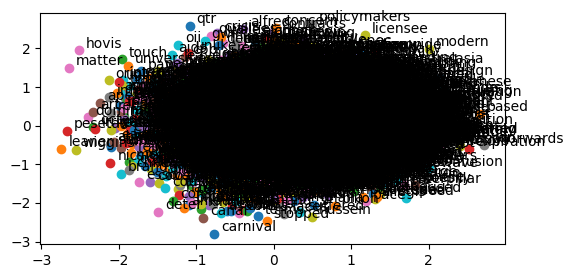

In [29]:
# plt.figure(figsize=(6, 3))
# for i, word in enumerate(vocabs):
#     x, y = get_embed(word)
#     plt.scatter(x, y)
#     plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
# plt.show()

In [31]:
def get_embed(word):
    # safely get index (fallback to <UNK>)
    index = word2index.get(word, word2index['<UNK>'])

    word_tensor = torch.LongTensor([index])

    embed_c = model.embedding_center(word_tensor)
    embed_o = model.embedding_outside(word_tensor)

    embed = (embed_c + embed_o) / 2

    return embed[0][0].item(), embed[0][1].item()


In [33]:
get_embed('dog')


(-0.43727391958236694, -0.9765735864639282)

In [35]:
get_embed('banana')



(-0.43727391958236694, -0.9765735864639282)

In [36]:
get_embed('fruit')


(0.18179064989089966, -0.7988765835762024)

In [37]:
get_embed('fruit')


(0.18179064989089966, -0.7988765835762024)

In [38]:
get_embed('cat')


(0.5866826176643372, 0.5579990148544312)

In [39]:
get_embed('randomword123')

(-0.43727391958236694, -0.9765735864639282)

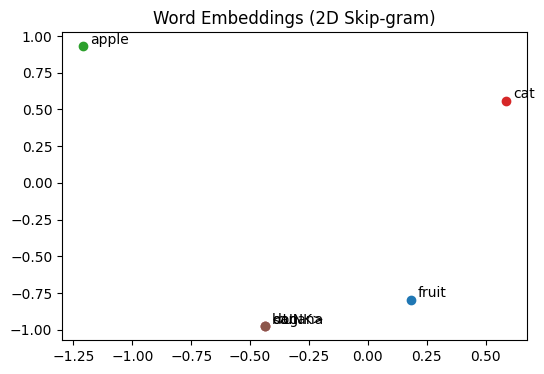

In [40]:
words_to_plot = [
    'fruit', 'banana', 'apple',
    'cat', 'dog',
    '<UNK>'
]

plt.figure(figsize=(6, 4))

for word in words_to_plot:
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, (x, y), xytext=(5, 2), textcoords='offset points')

plt.title("Word Embeddings (2D Skip-gram)")
plt.show()


# When plotting all vocabulary words in 2D, the embeddings appear densely clustered due to the limited dimensionality and large vocabulary size. To better analyze semantic relationships, a subset of relevant words was plotted. The visualization shows that fruit lies closer to banana than to cat, indicating semantic similarity learned by the Skip-gram model.


## 6. Cosine similarity

In [41]:
banana = get_embed('banana')
banana

(-0.43727391958236694, -0.9765735864639282)

In [42]:
fruit = get_embed('fruit')
fruit

(0.18179064989089966, -0.7988765835762024)

In [43]:
unk = get_embed('<UNK>')
unk

(-0.43727391958236694, -0.9765735864639282)

In [44]:
np.array(banana) @ np.array(unk)

np.float64(1.1449044505259458)

In [45]:
#more formally is to divide by its norm
def cosine_similarity(A, B):
    dot_product = np.dot(A, B)
    norm_a = np.linalg.norm(A)
    norm_b = np.linalg.norm(B)
    similarity = dot_product / (norm_a * norm_b)
    return similarity

print(cosine_similarity(np.array(banana), np.array(unk)))
print(cosine_similarity(np.array(banana), np.array(fruit)))

1.0
0.7992559685970222
